# Model Training and Evaluation for Patient Readmission Prediction

This notebook builds, trains, evaluates, and optimizes a Logistic Regression model for predicting patient readmission risk. We'll use the preprocessed data from the previous notebook to train the model and evaluate its performance using appropriate metrics.


## Cell 1: Imports

Import necessary libraries for model training, evaluation, and persistence.


In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load the preprocessed data
# Note: In a real workflow, you would load the preprocessed data from the previous notebook
# For this notebook to run independently, we'll reload and preprocess the data
# In practice, you would use %store or pickle to pass data between notebooks

print("\nLoading and preprocessing data...")
df = pd.read_csv('../data/synthetic_patient_data.csv')

# Handle missing values (simplified version for this notebook)
numerical_cols = ['age', 'length_of_stay', 'num_lab_procedures', 'num_medications']
categorical_cols = ['gender', 'admission_type', 'diagnosis_code']

for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Feature engineering: comorbidity score
np.random.seed(42)
comorbidity_scores = []
for idx, row in df.iterrows():
    score = 0
    if row['age'] > 75:
        score += 2
    elif row['age'] > 65:
        score += 1
    elif row['age'] > 50:
        score += 0.5
    if row['length_of_stay'] > 14:
        score += 2
    elif row['length_of_stay'] > 7:
        score += 1
    if row['num_medications'] > 15:
        score += 1.5
    elif row['num_medications'] > 10:
        score += 0.5
    high_complexity_codes = ['I10', 'E11', 'J44', 'N18']
    if row['diagnosis_code'] in high_complexity_codes:
        score += 1
    score += np.random.uniform(-0.5, 0.5)
    score = max(0, min(5, score))
    comorbidity_scores.append(round(score, 2))
df['comorbidity_score'] = comorbidity_scores

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, drop_first=False)

# Split data
from sklearn.model_selection import train_test_split
X = df_encoded.drop('readmitted', axis=1)
y = df_encoded['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✓ Data loaded and preprocessed!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Libraries imported successfully!

Loading and preprocessing data...
✓ Data loaded and preprocessed!
Training set: 800 samples
Test set: 200 samples


## Cell 2: Model Selection & Justification

**Model Choice: Logistic Regression**

We choose **Logistic Regression** for this healthcare prediction task because:

1. **Interpretability**: Logistic Regression provides interpretable coefficients, allowing us to understand which features contribute most to readmission risk. This is critical in healthcare where doctors need to understand model decisions.

2. **Probabilistic Output**: The model outputs probabilities, which can be used to assess risk levels and make informed decisions.

3. **Efficiency**: Logistic Regression is fast to train and suitable for binary classification problems like readmission prediction.

4. **Baseline Performance**: It serves as an excellent baseline model that can be compared against more complex models.

5. **Regulation Compliance**: In healthcare, interpretable models are often preferred for regulatory compliance and clinical validation.


## Cell 3: Initial Model Training

Train an initial Logistic Regression model with default parameters. This will serve as our baseline for comparison.


In [9]:
# Scale features for Logistic Regression
# Standardization helps Logistic Regression converge faster and perform better
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Training features shape: {X_train_scaled.shape}")

# Train initial Logistic Regression model with default parameters
# Default C=1.0 uses L2 regularization with moderate strength
model_initial = LogisticRegression(random_state=42, max_iter=1000)
model_initial.fit(X_train_scaled, y_train)

print("\n✓ Initial model trained successfully!")
print(f"Model parameters: C={model_initial.C}, penalty={model_initial.penalty}")


Features scaled using StandardScaler
Training features shape: (800, 19)

✓ Initial model trained successfully!
Model parameters: C=1.0, penalty=l2


## Cell 4: Initial Evaluation

Evaluate the initial model's performance using key metrics: confusion matrix, precision, and recall.

**Understanding the Metrics in Healthcare Context:**

- **Confusion Matrix**: Shows true positives, true negatives, false positives, and false negatives
  - **True Positives (TP)**: Correctly predicted readmissions
  - **True Negatives (TN)**: Correctly predicted non-readmissions
  - **False Positives (FP)**: Predicted readmission but didn't occur (Type I error)
  - **False Negatives (FN)**: Missed readmissions (Type II error)

- **Precision**: Of all patients predicted to be readmitted, how many actually were readmitted?
  - High precision means fewer false alarms (important for resource allocation)

- **Recall (Sensitivity)**: Of all actual readmissions, how many did we correctly identify?
  - High recall means we catch more actual readmissions (critical for patient safety)

In healthcare, we often prioritize **recall** over precision because missing a readmission (false negative) can have serious consequences for patient health.


INITIAL MODEL EVALUATION RESULTS

Confusion Matrix:
[[88 30]
 [46 36]]

Interpretation:
  True Negatives (TN): 88 - Correctly predicted non-readmissions
  False Positives (FP): 30 - Predicted readmission but didn't occur
  False Negatives (FN): 46 - Missed actual readmissions
  True Positives (TP): 36 - Correctly predicted readmissions

Performance Metrics:
  Accuracy:  0.6200 (62.00%)
  Precision: 0.5455 (54.55%)
  Recall:    0.4390 (43.90%)
  F1-Score:  0.4865

Detailed Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.66      0.75      0.70       118
    Readmitted       0.55      0.44      0.49        82

      accuracy                           0.62       200
     macro avg       0.60      0.59      0.59       200
  weighted avg       0.61      0.62      0.61       200



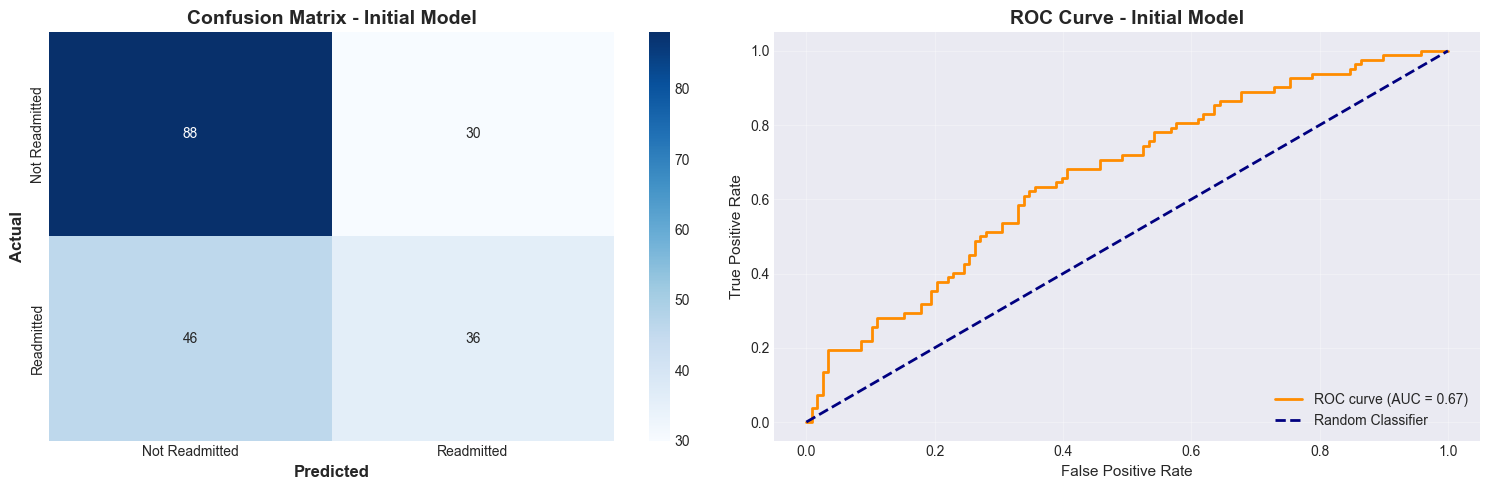


ROC AUC Score: 0.6654


In [10]:
# Make predictions on test set
y_pred_initial = model_initial.predict(X_test_scaled)
y_pred_proba_initial = model_initial.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_initial = accuracy_score(y_test, y_pred_initial)
precision_initial = precision_score(y_test, y_pred_initial)
recall_initial = recall_score(y_test, y_pred_initial)
f1_initial = f1_score(y_test, y_pred_initial)

# Confusion matrix
cm_initial = confusion_matrix(y_test, y_pred_initial)

print("="*60)
print("INITIAL MODEL EVALUATION RESULTS")
print("="*60)

print(f"\nConfusion Matrix:")
print(cm_initial)
print(f"\nInterpretation:")
print(f"  True Negatives (TN): {cm_initial[0, 0]} - Correctly predicted non-readmissions")
print(f"  False Positives (FP): {cm_initial[0, 1]} - Predicted readmission but didn't occur")
print(f"  False Negatives (FN): {cm_initial[1, 0]} - Missed actual readmissions")
print(f"  True Positives (TP): {cm_initial[1, 1]} - Correctly predicted readmissions")

print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {accuracy_initial:.4f} ({accuracy_initial*100:.2f}%)")
print(f"  Precision: {precision_initial:.4f} ({precision_initial*100:.2f}%)")
print(f"  Recall:    {recall_initial:.4f} ({recall_initial*100:.2f}%)")
print(f"  F1-Score:  {f1_initial:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_initial, target_names=['Not Readmitted', 'Readmitted']))

# Visualize confusion matrix and ROC curve for initial model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Confusion Matrix Heatmap
ax1 = axes[0]
cm_display = confusion_matrix(y_test, y_pred_initial)
sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix - Initial Model', fontsize=14, fontweight='bold')

# 2. ROC Curve
ax2 = axes[1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_initial)
roc_auc = roc_auc_score(y_test, y_pred_proba_initial)
ax2.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve - Initial Model', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")


## Cell 5: Optimization (Addressing Overfitting)

**L2 Regularization for Overfitting Prevention**

Overfitting occurs when a model learns the training data too well, including noise, which leads to poor generalization on new data. To address this:

1. **L2 Regularization (Ridge)**: Penalizes large coefficients, encouraging the model to use smaller, more generalizable weights.

2. **C Parameter**: Controls regularization strength. Lower C values mean stronger regularization:
   - `C=1.0` (default): Moderate regularization
   - `C=0.1`: Stronger regularization (prevents overfitting more aggressively)
   - `C=10.0`: Weaker regularization (allows more complex patterns)

We'll experiment with `C=0.1` to increase regularization and potentially improve generalization on the test set.


✓ Optimized model trained with C=0.1 (stronger regularization)
Model parameters: C=0.1, penalty=l2

Overfitting Analysis:
Initial Model:
  Training Accuracy: 0.6637
  Test Accuracy:     0.6200
  Gap:               0.0437

Optimized Model (C=0.1):
  Training Accuracy: 0.6663
  Test Accuracy:     0.6150
  Gap:               0.0513

Model performance comparison:


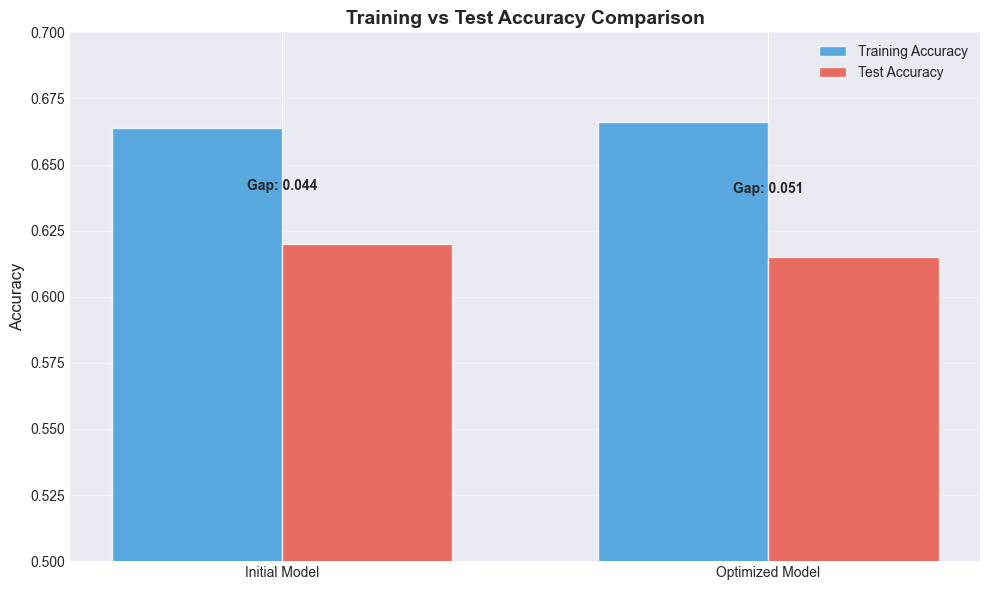

In [11]:
# Train optimized model with stronger L2 regularization (C=0.1)
# Lower C value means stronger regularization, which helps prevent overfitting
model_optimized = LogisticRegression(C=0.1, penalty='l2', random_state=42, max_iter=1000)
model_optimized.fit(X_train_scaled, y_train)

print("✓ Optimized model trained with C=0.1 (stronger regularization)")
print(f"Model parameters: C={model_optimized.C}, penalty={model_optimized.penalty}")

# Compare training and validation performance to check for overfitting
train_score_initial = model_initial.score(X_train_scaled, y_train)
test_score_initial = model_initial.score(X_test_scaled, y_test)

train_score_optimized = model_optimized.score(X_train_scaled, y_train)
test_score_optimized = model_optimized.score(X_test_scaled, y_test)

print(f"\nOverfitting Analysis:")
print(f"Initial Model:")
print(f"  Training Accuracy: {train_score_initial:.4f}")
print(f"  Test Accuracy:     {test_score_initial:.4f}")
print(f"  Gap:               {train_score_initial - test_score_initial:.4f}")

print(f"\nOptimized Model (C=0.1):")
print(f"  Training Accuracy: {train_score_optimized:.4f}")
print(f"  Test Accuracy:     {test_score_optimized:.4f}")
print(f"  Gap:               {train_score_optimized - test_score_optimized:.4f}")

if abs(train_score_optimized - test_score_optimized) < abs(train_score_initial - test_score_initial):
    print("\n✓ Regularization reduced overfitting (smaller gap between train and test)")
else:
    print("\nModel performance comparison:")

# Visualize overfitting analysis
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Initial Model', 'Optimized Model']
train_scores = [train_score_initial, train_score_optimized]
test_scores = [test_score_initial, test_score_optimized]

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, train_scores, width, label='Training Accuracy', color='#3498db', alpha=0.8)
ax.bar(x + width/2, test_scores, width, label='Test Accuracy', color='#e74c3c', alpha=0.8)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0.5, 0.7])
ax.grid(True, alpha=0.3, axis='y')

# Add gap annotations
for i, (train, test) in enumerate(zip(train_scores, test_scores)):
    gap = train - test
    ax.text(i, (train + test) / 2, f'Gap: {gap:.3f}', 
            ha='center', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


## Cell 6: Final Evaluation

Evaluate the optimized model and compare it with the initial model to see if regularization improved performance.


OPTIMIZED MODEL EVALUATION RESULTS

Confusion Matrix:
[[88 30]
 [47 35]]

Interpretation:
  True Negatives (TN): 88 - Correctly predicted non-readmissions
  False Positives (FP): 30 - Predicted readmission but didn't occur
  False Negatives (FN): 47 - Missed actual readmissions
  True Positives (TP): 35 - Correctly predicted readmissions

Performance Metrics:
  Accuracy:  0.6150 (61.50%)
  Precision: 0.5385 (53.85%)
  Recall:    0.4268 (42.68%)
  F1-Score:  0.4762

Detailed Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.65      0.75      0.70       118
    Readmitted       0.54      0.43      0.48        82

      accuracy                           0.61       200
     macro avg       0.60      0.59      0.59       200
  weighted avg       0.61      0.61      0.61       200


MODEL COMPARISON
Metric          Initial Model        Optimized Model      Change    
-----------------------------------------------------------------
Accura

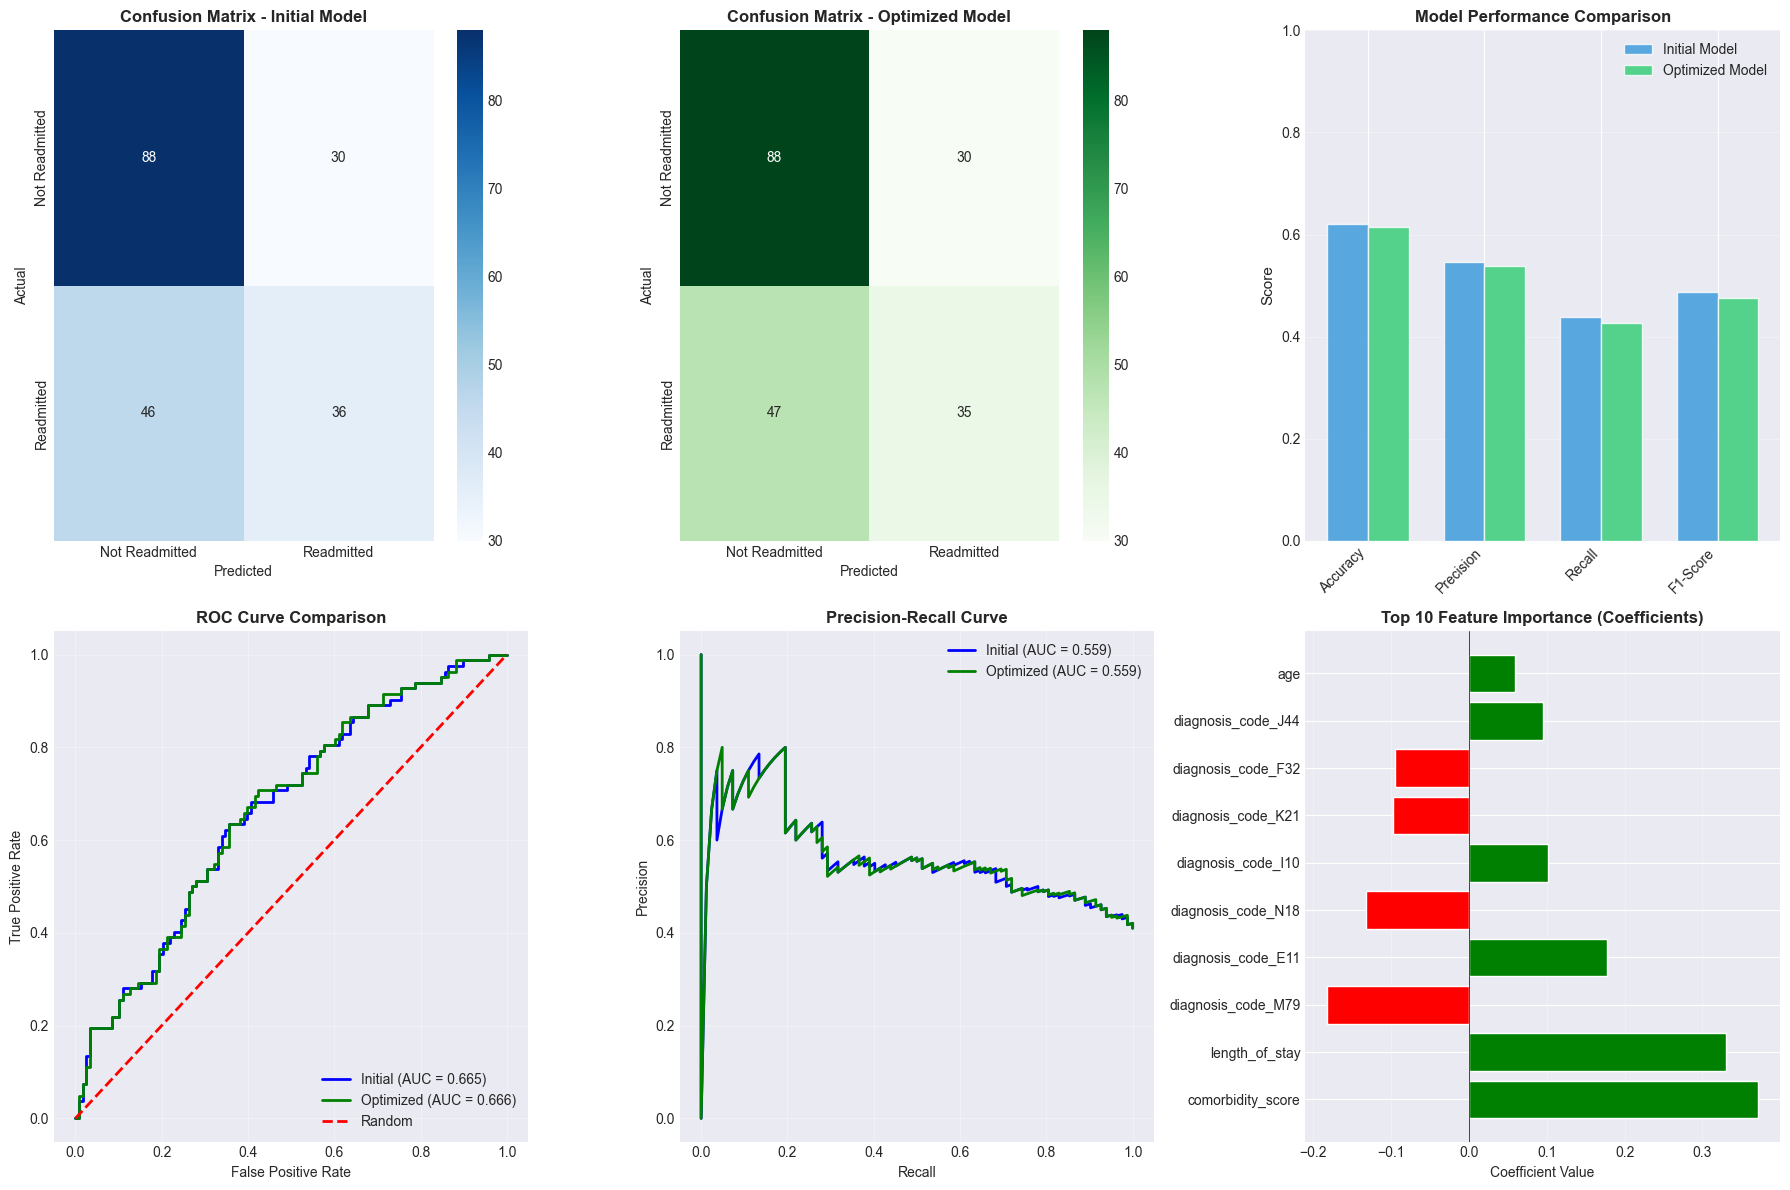


AUC SCORES
Initial Model - ROC AUC: 0.6654, PR AUC: 0.5590
Optimized Model - ROC AUC: 0.6662, PR AUC: 0.5592


In [12]:
# Make predictions with optimized model
y_pred_optimized = model_optimized.predict(X_test_scaled)
y_pred_proba_optimized = model_optimized.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)

# Confusion matrix for optimized model
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

print("="*60)
print("OPTIMIZED MODEL EVALUATION RESULTS")
print("="*60)

print(f"\nConfusion Matrix:")
print(cm_optimized)
print(f"\nInterpretation:")
print(f"  True Negatives (TN): {cm_optimized[0, 0]} - Correctly predicted non-readmissions")
print(f"  False Positives (FP): {cm_optimized[0, 1]} - Predicted readmission but didn't occur")
print(f"  False Negatives (FN): {cm_optimized[1, 0]} - Missed actual readmissions")
print(f"  True Positives (TP): {cm_optimized[1, 1]} - Correctly predicted readmissions")

print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {accuracy_optimized:.4f} ({accuracy_optimized*100:.2f}%)")
print(f"  Precision: {precision_optimized:.4f} ({precision_optimized*100:.2f}%)")
print(f"  Recall:    {recall_optimized:.4f} ({recall_optimized*100:.2f}%)")
print(f"  F1-Score:  {f1_optimized:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=['Not Readmitted', 'Readmitted']))

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"{'Metric':<15} {'Initial Model':<20} {'Optimized Model':<20} {'Change':<10}")
print("-" * 65)
print(f"{'Accuracy':<15} {accuracy_initial:<20.4f} {accuracy_optimized:<20.4f} {accuracy_optimized-accuracy_initial:>+7.4f}")
print(f"{'Precision':<15} {precision_initial:<20.4f} {precision_optimized:<20.4f} {precision_optimized-precision_initial:>+7.4f}")
print(f"{'Recall':<15} {recall_initial:<20.4f} {recall_optimized:<20.4f} {recall_optimized-recall_initial:>+7.4f}")
print(f"{'F1-Score':<15} {f1_initial:<20.4f} {f1_optimized:<20.4f} {f1_optimized-f1_initial:>+7.4f}")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
if f1_optimized > f1_initial:
    print("✓ The optimized model shows improved overall performance (F1-Score)")
elif f1_optimized == f1_initial:
    print("The optimized model shows similar performance")
else:
    print("The optimized model may need further tuning")

print("\nNote: In healthcare applications, recall (sensitivity) is often prioritized")
print("to ensure we catch as many actual readmissions as possible.")

# Comprehensive model comparison visualizations
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Comparison
ax1 = plt.subplot(2, 3, 1)
cm_initial_display = confusion_matrix(y_test, y_pred_initial)
sns.heatmap(cm_initial_display, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
ax1.set_title('Confusion Matrix - Initial Model', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

ax2 = plt.subplot(2, 3, 2)
cm_optimized_display = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_optimized_display, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
ax2.set_title('Confusion Matrix - Optimized Model', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 2. Metrics Comparison Bar Chart
ax3 = plt.subplot(2, 3, 3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
initial_scores = [accuracy_initial, precision_initial, recall_initial, f1_initial]
optimized_scores = [accuracy_optimized, precision_optimized, recall_optimized, f1_optimized]

x = np.arange(len(metrics))
width = 0.35
ax3.bar(x - width/2, initial_scores, width, label='Initial Model', color='#3498db', alpha=0.8)
ax3.bar(x + width/2, optimized_scores, width, label='Optimized Model', color='#2ecc71', alpha=0.8)
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics, rotation=45, ha='right')
ax3.legend()
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3, axis='y')

# 3. ROC Curve Comparison
ax4 = plt.subplot(2, 3, 4)
# Calculate ROC curves for both models
fpr_initial, tpr_initial, _ = roc_curve(y_test, y_pred_proba_initial)
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_optimized)
roc_auc_initial = roc_auc_score(y_test, y_pred_proba_initial)
roc_auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

ax4.plot(fpr_initial, tpr_initial, color='blue', lw=2, 
         label=f'Initial (AUC = {roc_auc_initial:.3f})')
ax4.plot(fpr_optimized, tpr_optimized, color='green', lw=2, 
         label=f'Optimized (AUC = {roc_auc_optimized:.3f})')
ax4.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
ax4.legend(loc="lower right")
ax4.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
ax5 = plt.subplot(2, 3, 5)
precision_initial_curve, recall_initial_curve, _ = precision_recall_curve(y_test, y_pred_proba_initial)
precision_optimized_curve, recall_optimized_curve, _ = precision_recall_curve(y_test, y_pred_proba_optimized)
pr_auc_initial = auc(recall_initial_curve, precision_initial_curve)
pr_auc_optimized = auc(recall_optimized_curve, precision_optimized_curve)

ax5.plot(recall_initial_curve, precision_initial_curve, color='blue', lw=2,
         label=f'Initial (AUC = {pr_auc_initial:.3f})')
ax5.plot(recall_optimized_curve, precision_optimized_curve, color='green', lw=2,
         label=f'Optimized (AUC = {pr_auc_optimized:.3f})')
ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 5. Feature Importance (Logistic Regression Coefficients)
ax6 = plt.subplot(2, 3, 6)
feature_names = X.columns
coefficients = model_optimized.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False).head(10)

ax6.barh(feature_importance['Feature'], feature_importance['Coefficient'], 
         color=feature_importance['Coefficient'].apply(lambda x: 'green' if x > 0 else 'red'))
ax6.set_xlabel('Coefficient Value')
ax6.set_title('Top 10 Feature Importance (Coefficients)', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print AUC scores
print(f"\n{'='*60}")
print("AUC SCORES")
print(f"{'='*60}")
print(f"Initial Model - ROC AUC: {roc_auc_initial:.4f}, PR AUC: {pr_auc_initial:.4f}")
print(f"Optimized Model - ROC AUC: {roc_auc_optimized:.4f}, PR AUC: {pr_auc_optimized:.4f}")


## Cell 7: Model Saving for Deployment

Save the trained and optimized model to disk using joblib. This allows the model to be loaded later for making predictions without retraining.

**Why this is crucial for deployment:**

1. **Model Persistence**: The trained model can be saved and reused without retraining
2. **Production Deployment**: The saved model can be loaded in production applications
3. **Version Control**: Different model versions can be saved and compared
4. **Efficiency**: Avoids retraining time when making predictions

We save both the model and the scaler, as new data must be scaled using the same scaler that was used during training.


In [13]:
# Create src directory if it doesn't exist
import os
os.makedirs('../src', exist_ok=True)

# Save the optimized model
model_path = '../src/readmission_model.joblib'
joblib.dump(model_optimized, model_path)
print(f"✓ Model saved to: {model_path}")

# Save the scaler (important for preprocessing new data)
scaler_path = '../src/scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Verify the saved model can be loaded
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

# Test the loaded model
test_predictions = loaded_model.predict(loaded_scaler.transform(X_test.iloc[:5]))
print(f"\n✓ Model loading verified!")
print(f"Sample predictions from loaded model: {test_predictions}")

print("\n" + "="*60)
print("MODEL DEPLOYMENT READY")
print("="*60)
print("The model and scaler have been saved and can be used for predictions.")
print("\nExample usage:")
print("```python")
print("import joblib")
print("model = joblib.load('src/readmission_model.joblib')")
print("scaler = joblib.load('src/scaler.joblib')")
print("# Preprocess new patient data")
print("X_new_scaled = scaler.transform(X_new)")
print("predictions = model.predict(X_new_scaled)")
print("probabilities = model.predict_proba(X_new_scaled)")
print("```")



✓ Model saved to: ../src/readmission_model.joblib
✓ Scaler saved to: ../src/scaler.joblib

✓ Model loading verified!
Sample predictions from loaded model: [1 0 1 0 1]

MODEL DEPLOYMENT READY
The model and scaler have been saved and can be used for predictions.

Example usage:
```python
import joblib
model = joblib.load('src/readmission_model.joblib')
scaler = joblib.load('src/scaler.joblib')
# Preprocess new patient data
X_new_scaled = scaler.transform(X_new)
predictions = model.predict(X_new_scaled)
probabilities = model.predict_proba(X_new_scaled)
```
